In [1]:
from time import time 

from jax import numpy as jnp, lax, random
from jax import vmap, jit
import matplotlib.pyplot as plt

In [2]:
# set a random key
key = random.PRNGKey(seed=1)

In [25]:
# parameters
d = 1
dt = 0.01
K = 100
x_init = 0 * jnp.ones((K, d))
r_lim = 5
subkeys = random.split(key, K)

In [16]:
# stop condition
cond_fn = lambda x, r_lim: jnp.where(jnp.linalg.norm(x) >= r_lim, True, False)

1. sample brownian motion fht with a while loop in the time-steps

In [17]:
def brownian_fht(x_init, key):

    # dimension
    d = x_init.shape[0]
    
    # initialize trajectory
    xt = x_init

    # trajectory list
    x = [xt]
    while not cond_fn(xt, r_lim):

        # brownian increments
        key, subkey = random.split(key)
        dbt = jnp.sqrt(dt) * random.normal(key, (d,))                                                  

        # update
        xt += dbt

        # save position
        x += [xt]
        
    return jnp.stack(x)

#brownian_fht = vmap(brownian_fht, in_axes=(0, 0), out_axes=1)
#sample_finite = jit(sample_finite, static_argnums=(0,))

In [18]:
x = brownian_fht(x_init[0], key)#; x#jnp.linalg.norm(x, axis=0).shape

In [19]:
x.shape

(1758, 3)

2. sample brownian motion fht using lax with while_loop

In [4]:
def cond_fn(val):
    _, xt, _ = val
    return jnp.where(jnp.linalg.norm(xt) <= r_lim, True, False)

def body_fn(val):
    step, xt, key = val
    d = xt.shape[0]
    key, subkey = random.split(key)
    dbt = jnp.sqrt(dt) * random.normal(key, (d,))
    step = step + 1
    return step, xt + dbt, key

def brownian_fht(x_init, key):
    return lax.while_loop(cond_fn, body_fn, (0, x_init, key))

brownian_fht = jit(vmap(brownian_fht))

In [5]:
%time steps, x_fht, _ = brownian_fht(x_init, subkeys)

CPU times: user 400 ms, sys: 6.36 ms, total: 407 ms
Wall time: 403 ms


In [22]:
#x_fht.shape, steps

3. sample brownian motion fht using lax with scan

In [33]:
def cond_fn(carry):
    _, xt, _ = carry
    return jnp.linalg.norm(xt) <= r_lim#, True, False)

def apply_fn(carry):
    step, xt, key = carry
    d = xt.shape[0]
    key, subkey = random.split(key)
    dbt = jnp.sqrt(dt) * random.normal(key, (d,))
    xt = xt + dbt
    step = step + 1
    return (step, xt + dbt, key)
    
def body_fn(carry, x):
    #carry = jnp.where(cond_fn(carry), apply_fn(carry), carry)
    carry = lax.cond(cond_fn(carry), apply_fn, lambda x: x, carry)
    return carry, carry[1]

def brownian_fht(x_init, key):
    return lax.scan(body_fn, init=(0, x_init, key), xs=None, length=int(1e3))

brownian_fht = jit(vmap(brownian_fht, out_axes=0))

In [43]:
#x_init.shape
cond_fn((0, x_init[0], key))

Array(True, dtype=bool)

In [34]:
#(steps, x_fht, _), _ = brownian_fht(x_init[0], key)
%time (steps, x_fht, _), x = brownian_fht(x_init, subkeys)

CPU times: user 226 ms, sys: 264 µs, total: 226 ms
Wall time: 221 ms


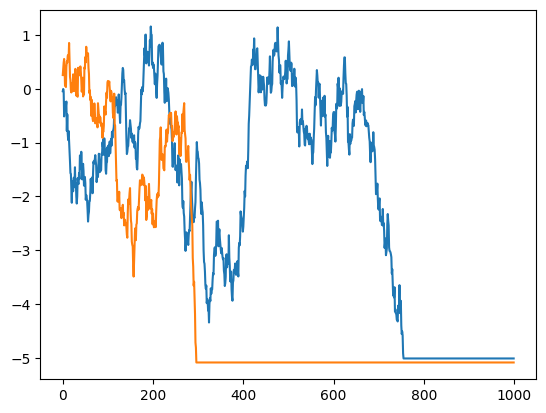

In [36]:
x.shape
plt.plot(x[0, :, 0])
plt.plot(x[1, :, 0])

In [13]:
def is_done(x):
    return x >= 10#jnp.where
    
@jit
def simulate_fht(carry, x):
    carry = jnp.where(is_done(carry), carry, carry + 1)
    return carry, None

In [14]:
lax.scan(simulate_fht, init=0, xs=None, length=20)

(Array(10, dtype=int32, weak_type=True), None)